# <center> Идентификация пользователей по посещенным веб-страницам
# План работы
## Введение
## Часть 1. Подготовка данных к анализу и построению моделей
## Часть 2. Первичный анализ данных и проверка гипотез
## Часть 3. Визуальный анализ данных и построение признаков
## Часть 4. Сравнение алгоритмов классификации
## Часть 5. Vowpal Wabbit

# Введение 
    
В этом проекте мы будем решать задачу идентификации пользователя по посещенным веб страницам
Задача состоит в следующем: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека.
    
В качестве исходных данных у нас есть каталоги с *.csv файлами для каждого пользователя с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:

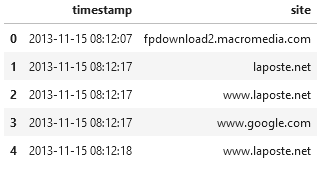
    
Данные устроены следующем образом:

 - В каталоге `10users` лежат 10 csv-файлов с названием вида "user[USER_ID].csv", где [USER_ID] – ID пользователя;
 - В каталоге `150users` 150 файлов пользователей соответственно;
 - Кроме того, у нас есть каталог `3users` с маленьким набором данных для трех пользователей. Будем им пользоваться для отладки кода
 
**В самом начале будет произведена предобработка данных и обзор, затем мы визуализируем данные и сделаем некоторые выводы. После этого сравним качество алгоритмов классификации на предобработанных данных, и в заключение попробуем поработать с библиотекой Vowpal Wabbit, чтобы оценить скороть ее работы на сравнительно большом объеме данных и сравним ее со скоростью работы других алгоритмов**

# Часть 1. Подготовка данных к анализу и построению моделей
### Постановка задачи: идентифицировать пользователя по 10 подряд посещенным сайтам

In [21]:
# Импортируем модули, которые нам понадобятся
import warnings
import time
warnings.filterwarnings('ignore')
from glob import glob
from collections import Counter
import os, pickle, re, warnings, itertools
from tqdm import tqdm 
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
PATH_TO_DATA = '' # эта константа будет использоваться для чтения файлов с данными

In [2]:
# Прочитаем данные из файла
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, '10users/user0031.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


Согласно постановке задачи, объектом будет сессия из посещенных подряд 10 сайтов, признаками - индексы этих сайтов. Целевым классом будет ID пользователя.

### Подготовка обучающей выборки
Реализуем функцию *prepare_train_set*, которая принимает на вход путь к каталогу с csv-файлами *path_to_csv_files* и параметр *session_length* – длину сессии, а возвращает 2 объекта:
- DataFrame, в котором строки соответствуют уникальным сессиям из *session_length* сайтов, *session_length* столбцов – индексам этих *session_length* сайтов и последний столбец – ID пользователя
- Частотный словарь сайтов вида {'site_string': (site_id, site_freq)}, например частотный словарь может выглядеть так {'vk.com': (1, 2), 'google.com': (2, 2), 'yandex.ru': (3, 3), 'facebook.com': (4, 1)}

Детали:
- Словарь будем заполнять по ходу чтения файлов
- Меньшие индексы будем присваивать наиболее часто встречающимся сайтам
- Скорее всего в файле число записей не кратно числу *session_length*. Тогда последняя сессия будет короче. Остаток заполним нулями. То есть если в файле 24 записи и сессии длины 10, то 3 сессия будет состоять из 4 сайтов, и ей мы сопоставим вектор [*site1_id*, *site2_id*, *site3_id*, *site4_id*, 0, 0, 0, 0, 0, 0, *user_id*] 

In [3]:
def prepare_train_set(path_to_csv_files, session_length=10):
    # "мешок сайтов". В этом списке будут все прочитанные сайты
    bag_of_sites = [] 
    
    # Обучающая выборка. Будем ее заполнять ID сайтов по ходу чтения файлов
    matrix_train = np.zeros((0, session_length))   
    
    # Пустой вектор ID пользователей
    user_id_vector = '' 
    
    # Получаем список файлов по заданному пути, читаем каждый файл и наполняем мешок сайтов
    files_list = glob(os.path.join(PATH_TO_DATA, path_to_csv_files) + '/*.csv')
    for filepath in files_list:
        user_data = pd.read_csv(os.path.join(PATH_TO_DATA, filepath))
        bag_of_sites += user_data['site'].tolist()
    
    # Формируем частотный словарь сайтов
    users_unique_sites = Counter(bag_of_sites).most_common()
    sites_ids = {users_unique_sites[site][0]: (site + 1, users_unique_sites[site][1]) for site in range(len(users_unique_sites))}

    # В этом цикле заполняем матрицу, чтобы вернуть ее как датафрейм
    for filepath in files_list:
        
        # Получаем ID пользователя из имени документа
        userid = re.findall(r'(\d+).csv', filepath)[0].lstrip('0')
        
        # Читаем данные пользователя
        user_data = pd.read_csv(os.path.join(PATH_TO_DATA, filepath))
        
        # Зададим нулевую матрицу пользователя и заполним ее. Пока она будет представлена как вектор
        user_matrix = np.zeros(len(user_data) if not len(user_data) % session_length else (len(user_data) - len(user_data) % session_length) + session_length)
        for i in range(user_matrix.shape[0]):
            if i < len(user_data):
                user_matrix[i] = sites_ids[user_data['site'].iloc[i]][0]
        
        # Превратим матрицу пользователя из строки в таблицу
        user_matrix = user_matrix.reshape((len(user_data) // session_length if not len(user_data) % session_length else len(user_data) // session_length + 1, session_length))
        
        # Добавим ID пользователя в вектор столько раз, сколько у пользователя сессий
        user_id_vector += (userid + ' ') * user_matrix.shape[0]
        
        # Добавим матрицу пользователя к обучающей выборке
        matrix_train = np.vstack((matrix_train, user_matrix))
        
    # Добавим к обучающей выборке вектор ответов (ID пользователей)    
    matrix_train = np.hstack((matrix_train, np.array(list(map(int, user_id_vector.split())))[:, np.newaxis]))
    
    # Сформируем из матрицы датафрейм и вернем
    df_train = pd.DataFrame(matrix_train)
    df_train.columns = ['site' + str(n) for n in range(1, session_length + 1)] + ['user_id']

    return df_train, sites_ids    

In [4]:
# Проверим работу функции на маленьком наборе данных
train_data_toy, site_freq_3users = prepare_train_set(os.path.join(PATH_TO_DATA, '3users'), session_length=10)
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,3.0,2.0,2.0,7.0,2.0,1.0,8.0,5.0,9.0,10.0,1.0
1,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.0,2.0,6.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
3,4.0,1.0,2.0,1.0,2.0,1.0,1.0,5.0,11.0,4.0,3.0
4,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


**Применим полученную функцию на наборы из 10 и 150 пользователей**

In [5]:
%%time
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users'), session_length=10)
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'), session_length=10)

Wall time: 29.6 s


In [6]:
train_data_10users.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,192.0,574.0,133.0,3.0,133.0,133.0,3.0,133.0,203.0,133.0,31.0
1,415.0,193.0,674.0,254.0,133.0,31.0,393.0,3305.0,217.0,55.0,31.0
2,55.0,3.0,55.0,55.0,5.0,293.0,415.0,333.0,897.0,55.0,31.0


**Для дальнейшего анализа запишем полученные объекты DataFrame в csv-файлы.**

In [7]:
train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 
                                       'train_data_10users.csv'), 
                        index_label='session_id', float_format='%d')
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 
                                        'train_data_150users.csv'), 
                         index_label='session_id', float_format='%d')

### Переход к разреженному формату данных

Воспользуемся идеей мешка слов из анализа текстов. Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки _i_ и столбца _j_ будет стоять число $n_{ij}$ – cколько раз сайт _j_ встретился в сессии номер _i_. Делать это будем с помощью разреженных матриц Scipy – [csr_matrix](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.html)

Добавим функцию _prepare_sparse_matrix_, которая переводит матрицу в разреженный формат

In [12]:
def prepare_sparse_matrix(dense_matrix):
    indexes, vals = [], []
    indptr = [0]
    vocab = {}
    for row in dense_matrix:
        for col in row:
            if col != 0:
                indexes.append(vocab.setdefault(col, col))
                vals.append(1)
        indptr.append(len(indexes))
    return csr_matrix((vals, indexes, indptr), dtype=int)[:, 1:]

In [9]:
# Применим функцию для наборов из 10 и 150 пользователей
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, train_data_10users.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, train_data_150users.iloc[:, -1].values

X_sparse_10users = prepare_sparse_matrix(X_10users)
X_sparse_150users = prepare_sparse_matrix(X_150users)

In [10]:
# Получили разреженные матрицы. Убедимся, что количество признаков в этих матрицах равно длине частотных словарей

print(X_sparse_10users.shape[1] == len(site_freq_10users))
print(X_sparse_150users.shape[1] == len(site_freq_150users))

True
True


**Сохраним эти разреженные матрицы с помощью [pickle](https://docs.python.org/2/library/pickle.html) (сериализация в Python), также сохраним вектора *y_10users, y_150users* – целевые значения (id пользователя)  в выборках из 10 и 150 пользователей. 
Cохраним также и частотные словари сайтов для 3, 10 и 150 пользователей.**

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_10users.pkl'), 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users, X10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'wb') as y10_pkl:
    pickle.dump(y_10users, y10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_150users.pkl'), 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_150users.pkl'), 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_3users.pkl'), 'wb') as site_freq_3users_pkl:
    pickle.dump(site_freq_3users, site_freq_3users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

# Часть 2. Первичный анализ данных и проверка гипотез
### Подготовка нескольких обучающих выборок для сравнения
Длина сессии 10 сайтов была определена случайно. Для сравнения моделей классификации предлагается сделать длину сессии параметром, чтобы была возможность обучать модели на выборках с длиной сессии 5, 7, 10 и т.д. Кроме того, применим дополнительно идею скользящего окна - сессии будут перекрываться

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в таблице ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

Реализуем функцию *prepare_sparse_train_set_window*.

Аргументы:
- *path_to_csv_files* – путь к каталогу с csv-файлами
- *site_freq_path* – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта
- *session_length* – длина сессии (параметр)
- *window_size* – ширина окна (параметр) 

Функция должна возвращать 2 объекта:
- разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
- вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*

In [12]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, session_length=10, window_size=7):
    
    # Загружаем частотный словарь и создаем пустые массивы данных для заполнения
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as pkl:
        sites_ids = pickle.load(pkl)
    files_list = glob(os.path.join(PATH_TO_DATA, path_to_csv_files) + '/*.csv')
    matrix_train = np.zeros((0, session_length))
    user_vector = np.array([])
    
    # С помощью index_shift будем регулировать смещение
    index_shift = session_length - window_size
    
    # Читаем данные пользователя и заполняем массивы данных по каждому прочитанному файлу
    for filepath in files_list:
        userid = int(re.findall(r'(\d+).csv', filepath)[0].lstrip('0'))
        user_data = pd.read_csv(os.path.join(PATH_TO_DATA, filepath))
        user_sites = np.array([sites_ids[site][0] for site in user_data['site'].to_numpy()])
        user_matrix = np.zeros(session_length * (len(user_data) // window_size + 1))
        user_matrix = user_matrix.reshape((int(user_matrix.shape[0] / session_length), session_length))
        
        # Заполнение первой строки матрицы
        if session_length > len(user_data):
            user_matrix[0][:len(user_data)] = user_sites[:len(user_data)]
        else:
            user_matrix[0] = user_sites[:session_length]
        
        # Заполнение всех последующих строк
        data_ind = session_length - 1
        for row in range(1, user_matrix.shape[0]):
            if np.sum(user_matrix[row - 1][-index_shift:]):
                user_matrix[row][:index_shift] = user_matrix[row - 1][-index_shift: None if index_shift else 0]
                for col in range(index_shift, session_length):
                    data_ind += 1
                    if data_ind < len(user_data):
                        user_matrix[row][col] = user_sites[data_ind]
        for row_ind in range(user_matrix.shape[0]):
            if int(np.sum(user_matrix[row_ind])) == 0:
                user_matrix = np.delete(user_matrix, row_ind, axis=0)
                
        # Добавляем данные по каждому пользователю в обучающую выборку
        matrix_train = np.vstack((matrix_train, user_matrix))
        user_vector = np.append(user_vector, [userid] * user_matrix.shape[0])
        #sparse_matrix_sess_win = prepare_sparse_matrix(matrix_train)

    return matrix_train, user_vector

In [16]:
# Проверим работу функции на наборе из 150 пользователей с длиной сессии 7 и шириной окна 5

%%time
m1 = prepare_sparse_train_set_window('150users', 'site_freq_150users.pkl', 7, 5)[0]
print(prepare_sparse_matrix(m1).shape)

(273957, 27797)
Wall time: 14.9 s


Теперь сгенерируем наборы данных и ответы согласно таблице параметров выше
В цикле перебираем параметры session_length и window_size, запускаем функцию и сохраняем результат как pickle файл
В результате получим 16 разреженных матриц и вектора ответов

In [17]:
%%time
import itertools

# В этот список запишем длины получившихся матриц
data_lengths = []

for num_users in [10, 150]:
    
    # делаем перебор параметров
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_name = 'X_sparse_' + str(num_users) + 'users_s' + str(session_length) + '_w' + str(window_size)
            y_name = 'y_' + str(num_users) + 'users_s' + str(session_length) + '_w' + str(window_size)
            X, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, str(num_users) + 'users'),
                                                                         os.path.join(PATH_TO_DATA, 'site_freq_' + str(num_users) + 'users.pkl'),
                                                                         session_length=session_length, window_size=window_size)
            X_sparse = prepare_sparse_matrix(X)

            with open(os.path.join(PATH_TO_DATA, X_name + '.pkl'), 'wb') as matrix:
                pickle.dump(X_sparse, matrix, protocol=2)

            with open(os.path.join(PATH_TO_DATA, y_name + '.pkl'), 'wb') as answers:
                pickle.dump(y, answers, protocol=2)

            data_lengths.append(X_sparse.shape[0])

print(data_lengths)

[14061, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 137019, 195712, 195712, 195712, 273957, 273957, 273957, 273957]
Wall time: 2min 9s


## Проверка гипотез

In [3]:
# Прочитаем ранее сохраненный файл 'train_data_10users.csv'

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'),    index_col='session_id')
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,31
1,415,193,674,254,133,31,393,3305,217,55,31
2,55,3,55,55,5,293,415,333,897,55,31
3,473,3306,473,55,55,55,55,937,199,123,31
4,342,55,5,3307,258,211,3308,2086,675,2086,31


**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [13]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] for i in range(train_df.values.shape[0])]
num_unique_sites[:10]

[5, 10, 7, 6, 9, 8, 7, 8, 8, 7]

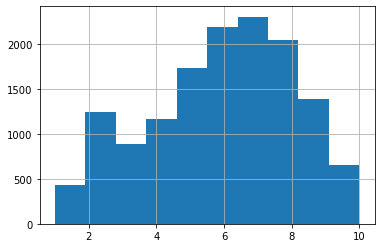

In [17]:
plt.hist(num_unique_sites)
plt.grid()
plt.show()

**Проверим с помощью QQ-плота , что эта величина распределена нормально**

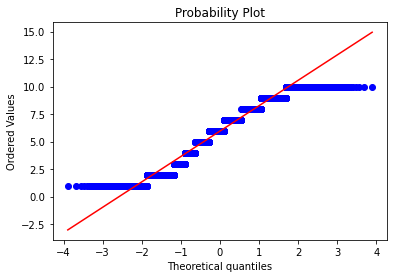

In [20]:
stats.probplot(num_unique_sites, dist='norm', plot=plt)
plt.show()

Изображение на QQ-плоте позволяет сделать вывод о том. что число уникальных сайтов в сессии не распределено нормально, потому что значения значения не выстроены по диагонали

**Проверим гипотезу о том, что пользователь в течении сессии хотя бы раз зайдет на сайт, который он уже ранее посетил. Проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%**

In [21]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [22]:
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), 0.95, alternative='greater')
print(pi_val)

0.02207653769072678


Полученное p-value позволяет принять гипотезу о том, что пользователь хотя бы раз в течении сессии из 10 сайтов посетит какой-нибудь из сайтов повторно

# Часть 3. Визуальный анализ данных и построение признаков

В этой части будет проведен визуальный анализ существующих признаков, а также будут построены дополнительные

Визуальный анализ будет проведен с помощью библиотеки seaborn

## Построение новых признаков

**На основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  добавим новую – *prepare_train_set_with_fe*, ("feature engineering"), которая генерирует следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    
    # Читаем частотный словарь и задаем начальные объекты:
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as pkl:
        sites_ids = pickle.load(pkl)
    files_list = glob(os.path.join(PATH_TO_DATA, path_to_csv_files) + '/*.csv')
    matrix_train = np.zeros((0, len(feature_names) - 5))
    user_vector, start_hours, week_day = np.array([]), np.array([]), np.array([])
    index_shift = session_length - window_size
    
    #Для каждого файла в каталоге формируем матрицу с сайтами и матрицу с time diff
    for filepath in files_list:
        userid = int(re.findall(r'(\d+).csv', filepath)[0].lstrip('0'))
        user_data = pd.read_csv(os.path.join(PATH_TO_DATA, filepath), parse_dates=['timestamp'], dayfirst=True)
        user_data['time_diff'] = [(user_data['timestamp'][i + 1] - user_data['timestamp'][i]).seconds if i < (len(user_data) - 1) else 0 for i in range(len(user_data))]
        user_sites = np.array([sites_ids[site][0] for site in user_data['site'].to_numpy()])
        matrix_sites = np.zeros((len(user_data) // window_size + 1, session_length))
        matrix_diffs = np.zeros((matrix_sites.shape[0], len(feature_names) - session_length - 5))

        if session_length > len(user_data):
            matrix_sites[0][:len(user_data)] = user_sites[:len(user_data)]
            matrix_diffs[0][:len(user_data)] = user_data['time_diff']
        else:
            matrix_sites[0] = user_sites[:session_length]
            matrix_diffs[0] = user_data['time_diff'][:matrix_diffs.shape[1]]


        data_ind = matrix_sites.shape[1] - 1
        diff_ind = data_ind
        for row in range(1, matrix_sites.shape[0]):
            if np.sum(matrix_sites[row - 1][-index_shift:]):
                matrix_sites[row][:index_shift] = matrix_sites[row - 1][-index_shift: None if index_shift else 0]
                matrix_diffs[row][:index_shift] = matrix_diffs[row - 1][-index_shift: None if index_shift else 0]
                for col in range(index_shift, session_length):
                    data_ind += 1
                    if data_ind < len(user_data):
                        matrix_sites[row][col] = user_sites[data_ind]
                for col_diff in range(index_shift, matrix_diffs.shape[1]):
                    diff_ind += 1
                    if diff_ind < len(user_data):
                        matrix_diffs[row][col_diff] = user_data['time_diff'][diff_ind]

        for row_ind in range(matrix_sites.shape[0]):
            if int(np.sum(matrix_sites[row_ind])) == 0:
                matrix_sites = np.delete(matrix_sites, row_ind, axis=0)
                matrix_diffs = np.delete(matrix_diffs, row_ind, axis=0)
            else:
                start_hours = np.append(start_hours, user_data['timestamp'][row_ind * session_length].hour)
                week_day = np.append(week_day, user_data['timestamp'][row_ind * session_length].weekday())
        
        #Соединяем матрицы сайтов и диффов для каждого пользователя между собой и затем стыкуем к основной матрице
        matrix_user_sites_diffs = np.hstack((matrix_sites, matrix_diffs))
        user_vector = np.append(user_vector, [userid] * matrix_user_sites_diffs.shape[0])
        matrix_train = np.vstack((matrix_train, matrix_user_sites_diffs))
        
    # преобразуем матрицу к дата фрейму и считаем значения оставшихся признаков
    df = pd.DataFrame(matrix_train, columns=feature_names[:19]).astype('int')
    df[feature_names[-5]] = df.iloc[:, [i for i in range(session_length, matrix_train.shape[1])]].sum(axis=1)
    df[feature_names[-4]] = df.iloc[:, [i for i in range(0, session_length)]].replace(0, np.NaN).nunique(axis=1, dropna=True)
    df[feature_names[-3]] = start_hours.astype('int')
    df[feature_names[-2]] = week_day.astype('int')
    df[feature_names[-1]] = user_vector.astype('int')

    return df

**Проверим функцию на примере из 3 файлов**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [6]:
train_data_toy.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,...,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,...,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,...,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1471,3,12,4,3


**Применим функцию *prepare_train_set_with_fe* к данным по 10 и 150 пользователям, укажем *session_length*=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               feature_names=feature_names, 
                                               session_length=10)

Wall time: 19.5 s


In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                                                site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                                feature_names=feature_names, session_length=10)

Wall time: 3min 35s


**Сохраним в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users.iloc[:, -5:-1]
new_features_150users = train_data_150users.iloc[:, -5:-1]

In [10]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

In [11]:
# Также сохраним в CSV файл обучающие выборки с добавленными признаками

train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 'train_data_fe_10users.csv'), index_label='session_id')
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 'train_data_fe_150users.csv'), index_label='session_id')

## Визуальный анализ данных

In [14]:
# Дадим пользователям имена и ассоциируем с ними цвета

id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

В этой части мы проведем визуальный анализ новых признаков по каждому из пользователей. После построения графиков будут предложены выводы по каждому из пользователей.
Будем строить гистограммы распределения в виде таблицы:
* по строкам разместим гистограммы конкретного пользователя
* по столбцам разместим признак, по которому строится диаграмма. В случае с диаграммой распределения длины сессии, будут рассмотрены только значения меньше 200, чтобы у диаграммы не было слишком тяжелого хвоста
* Имя пользователя выведем в легенду
* Цвет гистограммы присвоим согласно ассоциированным цветам пользователей

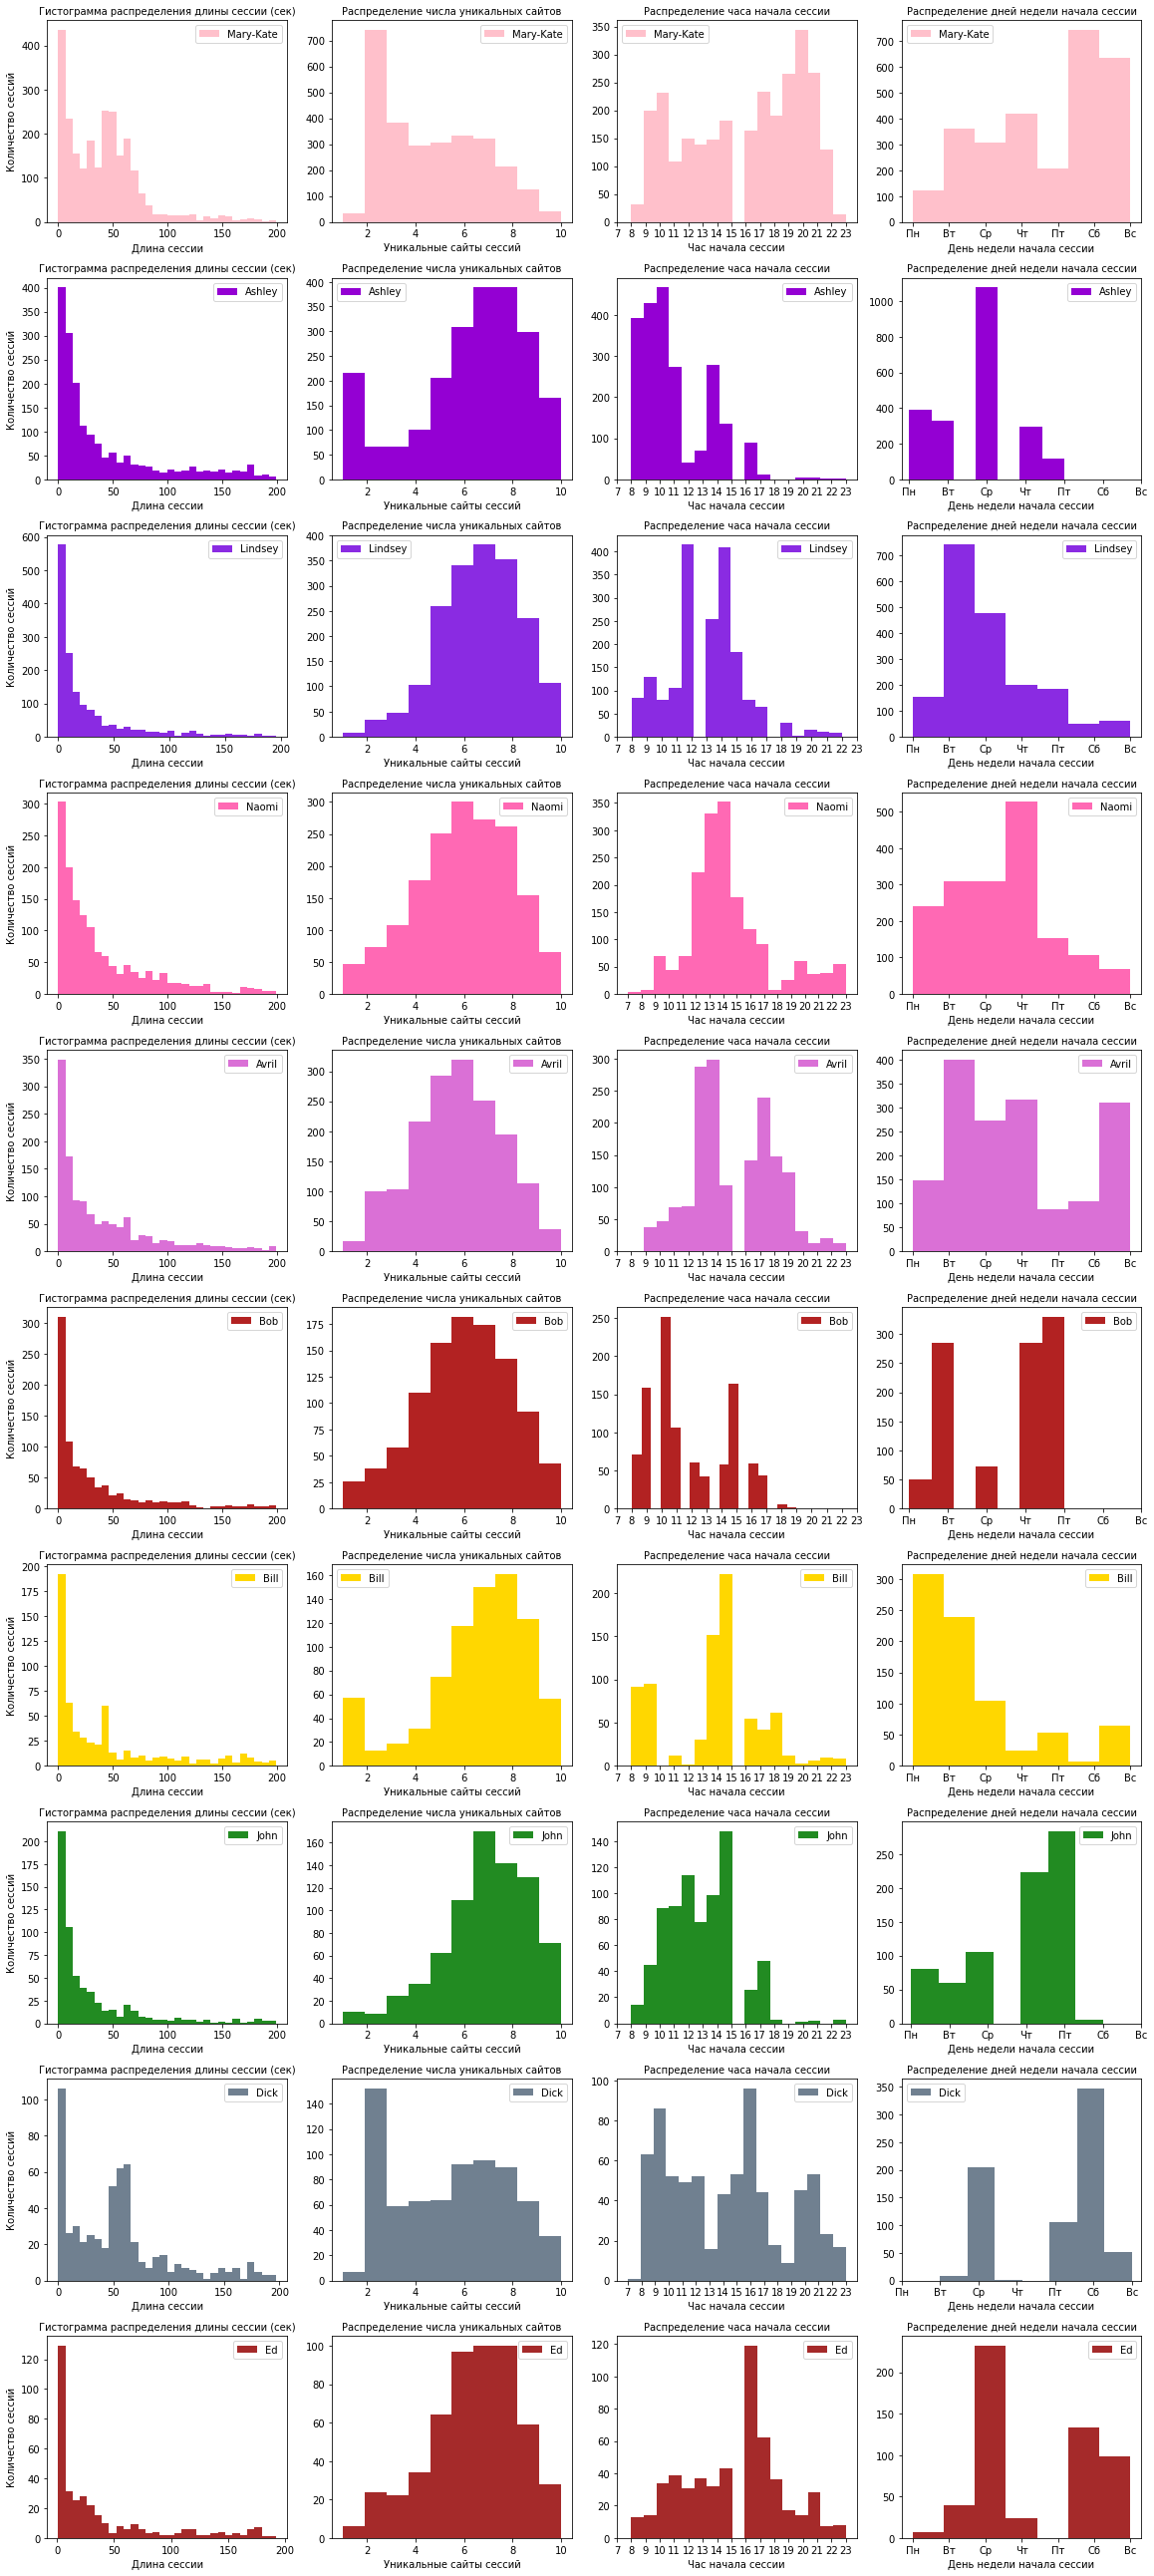

In [13]:
grouped_data = train_data_10users.groupby('target')

fig, axes = plt.subplots(nrows=len(id_name_dict.keys()), ncols=4, figsize=(16, 36))
for i, user_id in enumerate(list(id_name_dict.keys())):
    ax = axes[i]
    ax[0].hist(grouped_data.get_group(user_id)['session_timespan'][grouped_data.get_group(user_id)['session_timespan'] < 200], label=id_name_dict[user_id], bins=30, color=color_dic[id_name_dict[user_id]])
    ax[0].legend()
    ax[0].set_xlabel('Длина сессии')
    ax[0].set_title('Гистограмма распределения длины сессии (сек)', {'fontsize': 10})

    ax[1].hist(grouped_data.get_group(user_id)['#unique_sites'], label=id_name_dict[user_id], bins=train_data_10users['#unique_sites'].nunique(), color=color_dic[id_name_dict[user_id]])
    ax[1].legend()
    ax[1].set_xlabel('Уникальные сайты сессий')
    ax[1].set_title('Распределение числа уникальных сайтов', {'fontsize': 10})

    ax[2].hist(grouped_data.get_group(user_id)['start_hour'], label=id_name_dict[user_id], bins=train_data_10users['start_hour'].nunique(), color=color_dic[id_name_dict[user_id]])
    ax[2].set_xlabel('Час начала сессии')
    ax[2].legend()
    ax[2].set_title('Распределение часа начала сессии', {'fontsize': 10})
    ax[2].set_xticks(sorted(list(train_data_10users['start_hour'].unique())))

    ax[3].hist(grouped_data.get_group(user_id)['day_of_week'], label=id_name_dict[user_id], bins=train_data_10users['day_of_week'].nunique(), color=color_dic[id_name_dict[user_id]])
    ax[3].legend()
    ax[3].set_xlabel('День недели начала сессии')
    ax[3].set_title('Распределение дней недели начала сессии', {'fontsize': 10})
    ax[3].set_xticks(sorted(list(train_data_10users['day_of_week'].unique())))
    ax[3].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
fig.tight_layout()
plt.setp(axes[:, 0], ylabel='Количество сессий')
plt.show()

## Выводы по графикам

Распределение длины сессии у всех пользователей примерно одинаковое, преобладают сессии длиной до 20 секунд. Исключение составляют пользователи Mary-Kate и Dick. У этих пользователей достаточно много сессий длиной 50-80 секунд
По количеству уникальных сайтов распределение у всех пользователей похоже и составляет 6-8 уникальных сайтов за сессию

**Mary-Kate**

В большинстве случаев сессия имеет 2 уникальных сайта. Посещение сайтов в течении дня примерно одинаковое. Больше всего сессий наблюдается по выходным, меньше всего сессий по понедельникам и пятницам

**Ashley**

Больше всего сессий содержат от 6 до 8 уникалиных сайтов. При условии, что в среднем длина сессии у данного пользователя менее 30 секунд, это довольно большое количество посещенных сайтов. Время посещения сайтов в большинстве случаев в первой половине дня, с явно выраженным перерывом на обед с 12 до 14 часов. По выходным и 2 дня на буднях посещений нет. Вероятно, это стажер, который работает по пол дня

**Lindsey**

В основном сессии этого пользователя содержат 6-8 уникальных сайтов. Больше всего посещений за час до и два часа после обеда. Из дней недели по количествам посещений явно выделяются вторник и среда, в остальные дни количество сессий примерно одинаково

**Naomi**

В среднем 5-8 уникалиных сайтов, самое активное использование интернета в районе полудня и по четвергам

**April**

Активно пользуется интернетом после полудня и до вечера с небольним перерывом в районе 15 часов (может чай пьет :) ). Любит посещать сайты по выходным

**Bob**

Посещает сайты только по будням не каждый день, с частыми перерывами в течении дня.

**Bill**

Больше всего посещений с утра и в районе обеда, на неделе преимущественно до середины недели. В остальные дня посещает сайты не активно

**John**

За сессию чаще всего посещает 7 уникальных сайтов. Время посещений с утра до 15 часов преимущественно по четвергам и пятницам

**Dick**

У данного пользователя, в отличии от других, явно наблюдается большое количество сессий длиной более 50 секунд. Также примечательно то, что преобладает количество уникальных сайтов 2. Время посещений с утра и до позднего вечера с явно выраженными перерывами в районе обеда и 18 часов. На неделе посещений почти нет, кроме среды. По выходным более нагруженный день - суббота

**Ed**

После перерыва с 15 до 16 часов более активно посещает сайты, чем в другое время. На неделе больше всего посещений по средам и по выходным



**Определим топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [15]:
# Загружаем частотный словарь для 10 пользователей
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as pkl:
    site_freq_10users = pickle.load(pkl)
    
# Определяем топ-10 сайтов и количество их посещений
top10_sites = list(site_freq_10users.keys())[:10]
top10_freqs = [site_freq_10users[site][1] for site in top10_sites]

**Изобразим *seaborn barplot*, показывающий частоты посещений топ-10 сайтов**

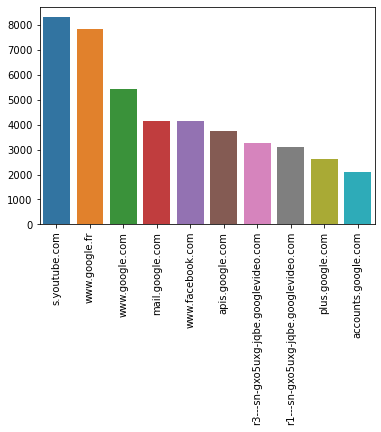

In [16]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(ticks=[i for i in range(len(top10_sites))], labels=top10_sites, rotation=90)
plt.show()

## Построение новых признаков

**Напишем функцию для создания новых признаков и применим ее к исходным данным – каталогам с 10 и 150 файлами. Сделаем это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Функция может возвращать как только новые признаки, так и старые с новыми**
 
 Чтобы не писать функцию заново, вызовем внутри нее prepare_train_set_with_fe и дополним несколько новых признаков:
 - 'is_weekend' - бинарный признак, является ли день недели, в который записана сессия, выходным или нет (1 если выходной, 0 если будни)
 - 'num_top30_visits' - количество сайтов сессии, которые входят в топ 30 сайтов по посещаемости
 - 'is_top30_first' - бинарный признак. Является ли первый сайт сессии сайтом из топ 30 (1 если является, 0 если нет)

In [17]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, session_length=10):
    df = prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
    df['num_top30_visits'] = df.iloc[:, :session_length].apply(lambda x: np.sum([x[i] in top_30_site_ids for i in range(session_length)]), axis=1)
    df['is_top30_first'] = df['site1'].apply(lambda x: 1 if x in top_30_site_ids else 0)
    return df[['is_weekend', 'num_top30_visits', 'is_top30_first']]

In [20]:
# для признака 'is_top30_first' нам понадобятся ID наиболее часто встречющихся сайтов
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as pkl:
    site_freq_10users = pickle.load(pkl)
top_30_site_ids_10users = [site_freq_10users[site][0] for site in list(site_freq_10users.keys())[:30]]

with open(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 'rb') as pkl:
    site_freq_150users = pickle.load(pkl)
top_30_site_ids_150users = [site_freq_150users[site][0] for site in list(site_freq_150users.keys())[:30]]

In [24]:
%%time
new_features_10users_fe = feature_engineering('10users', 'site_freq_10users.pkl', feature_names)

Wall time: 19.3 s


In [25]:
%%time
new_features_150users_fe = feature_engineering('150users', 'site_freq_150users.pkl', feature_names)

Wall time: 3min 35s


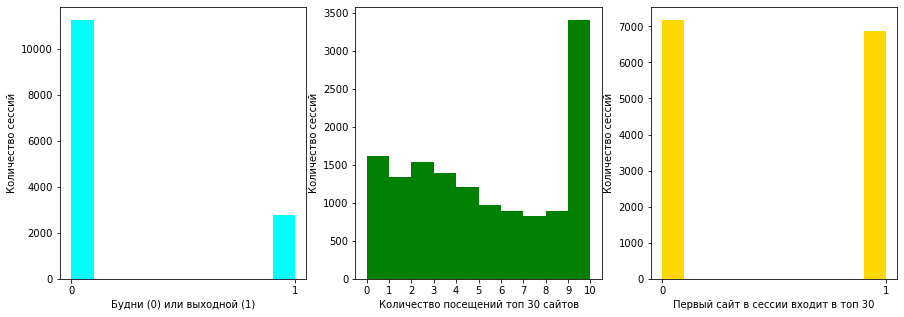

In [26]:
# Распределение значений новых признаков на наборе данных для 10 пользователей
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(new_features_10users_fe['is_weekend'], color='aqua')
plt.xlabel('Будни (0) или выходной (1)')
plt.ylabel('Количество сессий')
plt.xticks([0, 1])

plt.subplot(132)
plt.hist(new_features_10users_fe['num_top30_visits'], color='green')
plt.xticks(new_features_10users_fe['num_top30_visits'].unique())
plt.xlabel('Количество посещений топ 30 сайтов')
plt.ylabel('Количество сессий')

plt.subplot(133)
plt.hist(new_features_10users_fe['is_top30_first'], color='gold')
plt.xlabel('Первый сайт в сессии входит в топ 30')
plt.ylabel('Количество сессий')
plt.xticks([0, 1])

plt.show()

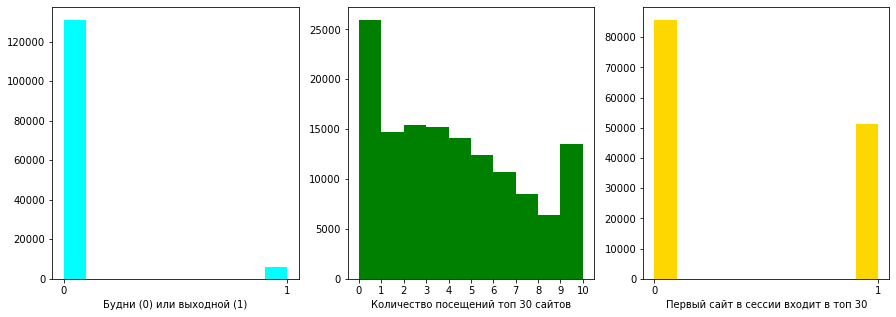

In [27]:
# Распределение значений новых признаков на наборе данных для 150 пользователей
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(new_features_150users_fe['is_weekend'], color='aqua')
plt.xlabel('Будни (0) или выходной (1)')
plt.xticks([0, 1])

plt.subplot(132)
plt.hist(new_features_150users_fe['num_top30_visits'], color='green')
plt.xticks(new_features_150users_fe['num_top30_visits'].unique())
plt.xlabel('Количество посещений топ 30 сайтов')

plt.subplot(133)
plt.hist(new_features_150users_fe['is_top30_first'], color='gold')
plt.xlabel('Первый сайт в сессии входит в топ 30')
plt.xticks([0, 1])

plt.show()

### Комментарии по новым признакам
Гистограммы 1 и 3 для разного количества пользователей имеют примерно одинаковый вид, т.е. на первой количество посещений по будням намного больше, чем в выходные. На третей гистограмме в обоих случаях прослеживается незначитальное преобладание сессий, которые начинаются с сайта, входящего в топ 30

На гистограмме 2 ситуация меняется. В случае 10 пользователей мы видим, что сессий, в которых посещаются только топ 30 сайтов, намного больше, чем остальных. Но когда мы смотрим эти данные для 150 пользователей, то явно заметно преобладание сессий, где топ 30 сайты не посещаются вообще. Для этого признака можно сделать вывод, что чем больше пользователей, тем больше он будет меняться и поможет более точно классифицировать данные

# Часть 4.  Сравнение алгоритмов классификации
## Выбор модели
В этой части мы подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

Будут рассмотрены следующие модели:
- KNeighborsClassifier
- RandomForestClassifier
- LogisticRegression
- LinearSVC с подбором параметров

In [2]:
# Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [3]:
X_sparse_10users.shape, y_10users.shape

((14061, 4913), (14061,))

In [4]:
# Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users.todense(), y_10users, test_size=0.3, random_state=17, stratify=y_10users)

In [5]:
# Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Обучим `KNeighborsClassifier` со 100 ближайшими соседями и посмотрим на долю правильных ответов на 3-кратной кросс-валидации по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`. Посчитаем доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлим каждое до 3 знаков после запятой**

In [6]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1).fit(X_train, y_train)

In [7]:
knn_results = ['KNeighborsClassifier', round(cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1).mean(), 3), round(metrics.accuracy_score(y_valid, knn.predict(X_valid)), 3)]
knn_results

['KNeighborsClassifier', 0.559, 0.584]

**Обучим случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрим на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`**

In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1).fit(X_train, y_train)

In [9]:
rf_results = ['RandomForestClassifier', round(cross_val_score(rf, X_train, y_train, cv=skf, n_jobs=-1).mean(), 3), round(metrics.accuracy_score(y_valid, rf.predict(X_valid)), 3)]
rf_results

['RandomForestClassifier', 0.718, 0.731]

**Обучим логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17. Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`**

In [10]:
lr = LogisticRegression(random_state=17, solver='liblinear').fit(X_train, y_train)

In [11]:
lr_results = ['LogisticRegression', round(cross_val_score(lr, X_sparse_10users, y_10users, cv=skf, n_jobs=-1).mean(), 3), round(metrics.accuracy_score(y_valid, lr.predict(X_valid)), 3)]
lr_results

['LogisticRegression', 0.778, 0.782]

**Обучим линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17. Посмотрим на долю правильных ответов на кросс-валидации (используем объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [12]:
svm = LinearSVC(C=1, random_state=17, max_iter=10000).fit(X_train, y_train)

In [21]:
svm_results = ['LinearSVC', round(cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1).mean(), 3), round(metrics.accuracy_score(y_valid, svm.predict(X_valid)), 3)]
svm_results

['LinearSVC', 0.751, 0.777]

**С помощью `GridSearchCV` подберем параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используя `linspace` из NumPy**

In [15]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
svm_grid_searcher = GridSearchCV(LinearSVC(random_state=17), svm_params2, n_jobs=-1).fit(X_train, y_train)

Wall time: 1min 41s


In [19]:
# Выведем наилучшие параметры модели и значение accuracy на отложеннои выборке
C_svm = svm_grid_searcher.best_params_['C']
print('Наилучшие параметр C модели SVM: {}, Значение Accuracy: {}'.format(C_svm, metrics.accuracy_score(y_valid, svm.predict(X_valid))))

Наилучшие параметр C модели SVM: 0.10434482758620689, Значение Accuracy: 0.7769613652524295


**Посчитаем доли правильных ответов для `svm_grid_searcher` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлим каждое до 3 знаков после запятой**

In [23]:
svm_clf = LinearSVC(C=C_svm, random_state=17).fit(X_train, y_train)
svm_results_clf = ['LinearSVC with params', round(cross_val_score(svm_clf, X_train, y_train, cv=skf, n_jobs=-1).mean(), 3), round(metrics.accuracy_score(y_valid, svm_clf.predict(X_valid)), 3)]
svm_results_clf

['LinearSVC with params', 0.767, 0.781]

### Выведем результаты в виде таблицы

С небольшим преимуществом логистическая регрессия дала лучший результат

In [29]:
df_models = pd.DataFrame().from_records([knn_results, rf_results, lr_results, svm_results, svm_results_clf])
df_models.columns = ['Model', 'CV score', 'Accuracy']
df_models.sort_values('CV score', ascending=False)

,Model,CV score,Accuracy
2,LogisticRegression,0.778,0.782
4,LinearSVC with params,0.767,0.781
3,LinearSVC,0.751,0.777
1,RandomForestClassifier,0.718,0.731
0,KNeighborsClassifier,0.559,0.584


## Выбор параметров – длины сессии и ширины окна

**Возьмем `LogisticRegression`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Параметр регуляризации `C` также возьмем из предыдущей части**

**Определим функцию `model_assessment`, которая принимает на вход модель, пути к обучающей выборке и ответам и возвращает accuracy на тестовой выборке**

In [35]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    
    # будем измерять время работы функции
    start_time = time.time()
    with open(path_to_X_pickle, 'rb') as X_pkl:
        X = pickle.load(X_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    # разбиваем выборку и считаем accuracy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    estimator.fit(X_train, y_train)

    mean_cv_acc = round(cross_val_score(estimator, X_train, y_train, cv=skf, n_jobs=-1).mean(), 3)
    acc = round(metrics.accuracy_score(y_test, estimator.predict(X_test)), 3)

    return mean_cv_acc, acc, "%s seconds" % round((time.time() - start_time))

In [42]:
# проверка работы функции
model_assessment(lr, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.763, 0.782, '1 seconds')

**Применим функцию *model_assessment* для логистической регрессии и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведем в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*.**

In [39]:
%%time
estimator = lr

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        print('S:', session_length, 'W:', window_size, 'Results: ', model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

S: 15 W: 10 Results:  (0.825, 0.842, '3 seconds')
S: 10 W: 10 Results:  (0.763, 0.782, '1 seconds')
S: 15 W: 7 Results:  (0.851, 0.852, '4 seconds')
S: 10 W: 7 Results:  (0.798, 0.807, '2 seconds')
S: 7 W: 7 Results:  (0.751, 0.758, '1 seconds')
S: 15 W: 5 Results:  (0.867, 0.876, '4 seconds')
S: 10 W: 5 Results:  (0.817, 0.828, '3 seconds')
S: 7 W: 5 Results:  (0.77, 0.784, '2 seconds')
S: 5 W: 5 Results:  (0.722, 0.734, '2 seconds')
Wall time: 21.8 s


In [43]:
%%time
estimator = lr

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        print('S:', session_length, 'W:', window_size, 'Results: ', model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

S: 15 W: 10 Results:  (0.548, 0.574, '1055 seconds')
S: 10 W: 10 Results:  (0.461, 0.482, '579 seconds')
S: 15 W: 7 Results:  (0.583, 0.611, '1818 seconds')
S: 10 W: 7 Results:  (0.501, 0.524, '1244 seconds')
S: 7 W: 7 Results:  (0.434, 0.452, '815 seconds')
S: 15 W: 5 Results:  (0.614, 0.639, '3369 seconds')
S: 10 W: 5 Results:  (0.527, 0.548, '2461 seconds')
S: 7 W: 5 Results:  (0.465, 0.482, '1733 seconds')
S: 5 W: 5 Results:  (0.406, 0.422, '1203 seconds')
Wall time: 3h 57min 56s


### По результатам видно, что на выборке из 150 пользователей классификатор показывает гораздо меньшие результаты, чем на выборке из 10 пользователей. Однако заметно, что при длине сессии 15 и ширине окна 5 классификатор показывает лучшие результаты на обеих выборках

Многоклассовая доля ответов на выборке из 150 пользователей достаточно мала, однако попробуем идентифицировать конкретного пользователя

In [45]:
# Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей 
# с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%

with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [46]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                                      random_state=17, stratify=y_150users)

**Обучим `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажем аргумент `multi_class`='ovr'**

In [52]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[C_svm], cv=skf, multi_class='ovr', n_jobs=-1, random_state=17, max_iter=1000)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 2min 48s


LogisticRegressionCV(Cs=[0.10434482758620689],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     max_iter=1000, multi_class='ovr', n_jobs=-1,
                     random_state=17)

**Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности**

In [54]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User: {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User: 6.0, CV score: 0.9953291003305079
User: 13.0, CV score: 0.9958816844431934
User: 15.0, CV score: 0.9948390729098245
User: 16.0, CV score: 0.9910960975050306
User: 28.0, CV score: 0.9892611012063015
User: 31.0, CV score: 0.994422028296477
User: 33.0, CV score: 0.9932334511484365
User: 39.0, CV score: 0.9852470468028317
User: 46.0, CV score: 0.997591567357918
User: 49.0, CV score: 0.9943490454891412
User: 50.0, CV score: 0.9942760626818054
User: 53.0, CV score: 0.9933168600711061
User: 65.0, CV score: 0.996924295976562
User: 66.0, CV score: 0.9949746124091625
User: 82.0, CV score: 0.9963091551718746
User: 85.0, CV score: 0.9962674507105399
User: 89.0, CV score: 0.9902411560476683
User: 92.0, CV score: 0.9941405231824675
User: 100.0, CV score: 0.9947660901024887
User: 102.0, CV score: 0.990814592391021
User: 103.0, CV score: 0.9783345323365967
User: 105.0, CV score: 0.996423842440545
User: 106.0, CV score: 0.9936922002231189
User: 118.0, CV score: 0.9900534859716618
User: 119.0, CV 

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитаем для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [59]:
# получаем распределение ID пользователей
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = []
for user_id in np.unique(y_train_150.astype('int')):
    
    # доля правильных ответов на крос валидации
    cv_score = cv_scores_by_user[user_id]
    
    # доля меток пользователя в ответах обучающей выборки
    user_label_percentage = 1 - class_distr[user_id] / len(y_train_150)
    
    # разница
    acc_diff_vs_constant.append(cv_score - user_label_percentage)
    
# выводим количество ответов, разница с константным прогнозом у которых больше нуля    
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()
num_better_than_default

130

**Посчитаем долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлим до 3 знаков после запятой**

In [60]:
print(round(num_better_than_default / len(np.unique(y_train_150)), 3))

0.867


# Часть 5. Vowpal Wabbit
В этой части мы рассмотрим популярную библиотеку для анализа текстов Vowpal Wabbit и попробуем применить ее в задаче идентификации пользователей. Но на этот раз у нас будет 400 пользователей.
Данные взяты [из соревнования Kaggle](https://kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data) – файлы `train_sessions_400users.csv` и `test_sessions_400users.csv`
Основной задачей этой части является демонстрация скорости работы Vowpal Wabbit в сравнении с другими моделями. В качестве результата будут приведены в сравнении показатели точности и скорости работы нескольких классификаторов

In [2]:
# Поменяем на свой путь к данным для vowpal wabbit
PATH_TO_DATA = 'vw'

In [3]:
# Загрузим данные
train_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'train_sessions_400users.csv'), index_col='session_id')
test_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'test_sessions_400users.csv'), index_col='session_id')

In [4]:
train_df_400.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,...,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,...,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,...,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,...,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,...,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


**Vowpal Wabbit любит, чтобы метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 400). Поэтому придется применить `LabelEncoder`, и добавить +1 (поскольку `LabelEncoder` переводит метки в диапозон от 0 до K-1). Потом надо будет применить обратное преобразование.**

In [5]:
y = train_df_400['user_id']
class_encoder = LabelEncoder()
class_encoder.fit(train_df_400['user_id'])
y_for_vw = class_encoder.transform(train_df_400['user_id']) + 1

In [9]:
y_for_vw

array([262,  82,  16, ..., 254,  91, 256], dtype=int64)

**Далее будем сравнивать VW с SGDClassifier и с логистической регрессией. Всем моделям этим нужна предобработка входных данных. Подготовим для sklearn-моделей разреженные матрицы:**
- объединим обучающиую и тестовую выборки
- выберем только сайты (признаки от 'site1' до 'site10')
- заменим пропуски на нули
- переведем матрицы в разреженный формат `csr_matrix`
- разделим обратно на обучающую и тестовую части

In [10]:
sites = ['site' + str(i) for i in range(1, 11)]

In [13]:
# объединяем исходные выборки и выделаем датафрейм только с признаками сайтов
df_train_test_united = pd.concat([train_df_400, test_df_400])
df_train_test_united_sites = df_train_test_united[sites].fillna(0)

# переводим матрицу в разреженный формат
m_train_test_united_sites_sparse = prepare_sparse_matrix(df_train_test_united_sites.values)

train_ind = len(train_df_400)

# обучающая и тестовая выборки в разреженном формате
X_train_sparse = m_train_test_united_sites_sparse[:train_ind]
X_test_sparse = m_train_test_united_sites_sparse[train_ind:]
y = y

In [14]:
# проверим правильность размеров выборок
print(X_train_sparse.shape, X_test_sparse.shape, y.shape)
print(df_train_test_united.shape[0] == X_train_sparse.shape[0] + X_test_sparse.shape[0])

(182793, 36656) (46473, 36656) (182793,)
True


## Валидация по отложенной выборке

**Выделим обучающую (70%) и отложенную (30%) части исходной обучающей выборки train_df_400, т.к. именно эта часть имеет ответы - значения признака 'user_id'. Данные не перемешиваем, учитываем, что сессии отсортированы по времени**

In [15]:
train_share = int(.7 * train_df_400.shape[0])

# обучающая и тестовая выборки в не разреженном формате
train_df_part = train_df_400[sites].iloc[:train_share, :]
valid_df = train_df_400[sites].iloc[train_share:, :]

# обучающая и тестовая выборки в разреженном формате
X_train_part_sparse = X_train_sparse[:train_share, :]
X_valid_sparse = X_train_sparse[train_share:, :]

In [16]:
# ответы для модели SGDClassifier
y_train_part = y[:train_share]
y_valid = y[train_share:]

# ответы для VW
y_train_part_for_vw = y_for_vw[:train_share]
y_valid_for_vw = y_for_vw[train_share:]

**Реализуем функцию, `arrays_to_vw`, переводящую обучающую выборку в формат Vowpal Wabbit**

Вход:
 - X – матрица `NumPy` (обучающая выборка)
 - y - вектор ответов (`NumPy`). Необязателен, поскольку тестовую матрицу будем обрабатывать этой же функцией
 - train – флаг, True в случае обучающей выборки, False – в случае тестовой выборки
 - out_file – путь к файлу .vw, в который будет произведена запись
 
Детали:
- будем проходить по всем строкам матрицы `X` и записывать через пробел все значения, предварительно добавив вперед нужную метку класса из вектора `y` и знак-разделитель `|`
- в тестовой выборке на месте меток целевого класса можно писать произвольные, будем писать 1

In [17]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    with open(os.path.join(PATH_TO_DATA, out_file), 'a') as output:
        if y is not None:
            for label, features in zip(y, X.values):
                output.write((str(label) if train else '1') + ' | ' + ' '.join(features.astype('int').astype('str')) + '\n')
        else:
            for features in X.values:
                output.write(('1 ' if not train else ' ') + '| ' + ' '.join(features.astype('int').astype('str')) + '\n')
    return

**Применим написанную функцию к части обучащей выборки `(train_df_part, y_train_part_for_vw)`, к отложенной выборке `(valid_df, y_valid_for_vw)`, ко всей обучающей выборке и ко всей тестовой выборке**

In [15]:
%%time
# будет 4 вызова
arrays_to_vw(train_df_part, y_train_part_for_vw, train=True, out_file='train_part.vw')
arrays_to_vw(valid_df, y_valid_for_vw, train=True, out_file='valid.vw')
arrays_to_vw(df_train_test_united_sites, y_for_vw, train=True, out_file='train.vw')
arrays_to_vw(test_df_400[sites], train=False, out_file='test.vw')

Wall time: 10.5 s


In [16]:
# проверим, что данные записались в файл
with open('vw/train_part.vw', 'r') as file:
    for line in file.readlines()[:3]:
        print(line.strip())

262 | 23713 23720 23713 23713 23720 23713 23713 23713 23713 23713
82 | 8726 8725 665 8727 45 8725 45 5320 5320 5320
16 | 303 19 303 303 303 303 303 309 303 303


**Обучим модель Vowpal Wabbitна выборке `train_part.vw`. Укажем, что решается задача классификации с 400 классами (`--oaa`), сделаем 3 прохода по выборке (`--passes`). Зададим некоторый кэш-файл (`--cache_file`), так VW будет быстрее делать все следующие после первого проходы по выборке (прошлый кэш-файл удаляется с помощью аргумента `-k`). Также укажем значение параметра `b`=26. Это число бит, используемых для хэширования, в данном случае нужно больше, чем 18 по умолчанию. Наконец, укажем `random_seed`=17. Остальные параметры оставим по умолчанию**

In [18]:
cd "C:\Program Files\VowpalWabbit"

C:\Program Files\VowpalWabbit


In [20]:
%%time
!vw -d "C:\Users\alexey.barinov\PycharmProjects\pythonProject\Coursera\Course6\Project1_UsersBehavior\vw\train_part.vw" --oaa 400 --passes 3 -c -k -b 26 --random_seed 17 --quiet\
-f "C:\Users\alexey.barinov\PycharmProjects\pythonProject\Coursera\Course6\Project1_UsersBehavior\vw\model_train_part.vw"

Wall time: 1min 11s


**Запишем прогнозы на выборке *valid.vw* в *vw_valid_pred.csv*.**

In [23]:
%%time
!vw --quiet -i "C:\Users\alexey.barinov\PycharmProjects\pythonProject\Coursera\Course6\Project1_UsersBehavior\vw\model_train_part.vw" -t -d\
"C:\Users\alexey.barinov\PycharmProjects\pythonProject\Coursera\Course6\Project1_UsersBehavior\vw\valid.vw" \
-p "C:\Users\alexey.barinov\PycharmProjects\pythonProject\Coursera\Course6\Project1_UsersBehavior\vw\vw_valid_pred.csv"

Wall time: 2.3 s


**Прочитаем прогнозы *vw_valid_pred.csv* из файла и посмотрим на долю правильных ответов на отложенной части**

In [18]:
# для начала выполним обратное кодирование ответов, которое мы делали ранее с помощью LabelEncoder. Вычтем 1 из вектора правильных ответов, которую также прибавили ранее для удобства VW
class_decoder = class_encoder.inverse_transform(y_for_vw - 1)

In [19]:
vw_valid_predict = pd.read_csv("C:\\Users\\alexey.barinov\\PycharmProjects\\pythonProject\\Coursera\\Course6\\Project1_UsersBehavior\\vw\\vw_valid_pred.csv", header=None)
print(metrics.accuracy_score(y_valid, class_encoder.inverse_transform(vw_valid_predict.values.flatten() - 1)))

0.34541741128414605


**Теперь обучим `SGDClassifier` (3 прохода по выборке, логистическая функция потерь) и `LogisticRegression` на 70% разреженной обучающей выборки – `(X_train_part_sparse, y_train_part)`, сделаем прогноз для отложенной выборки `(X_valid_sparse, y_valid)` и посчитаем доли верных ответов**

In [22]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
sgd_logit = SGDClassifier(loss='log', n_iter_no_change=3, random_state=17, n_jobs=-1, max_iter=3)

In [23]:
%%time
logit.fit(X_train_part_sparse, y_train_part)

Wall time: 14min 17s


LogisticRegression(n_jobs=-1, random_state=17)

In [24]:
%%time
sgd_logit.fit(X_train_part_sparse, y_train_part)

Wall time: 9.55 s


SGDClassifier(loss='log', max_iter=3, n_iter_no_change=3, n_jobs=-1,
              random_state=17)

**Посчитаем долю правильных ответов на отложенной выборке для всех моделей и время, затраченное на обучение**

In [50]:
vw_valid_acc = float(metrics.accuracy_score(y_valid, class_encoder.inverse_transform(vw_valid_predict.values.flatten() - 1)))
sgd_valid_acc = float(metrics.accuracy_score(y_valid, sgd_logit.predict(X_valid_sparse)))
logit_valid_acc = float(metrics.accuracy_score(y_valid, logit.predict(X_valid_sparse)))

In [57]:
df_vw_results = pd.DataFrame().from_records([['Vowpal Wabbit', vw_valid_acc, '2.3 s'], ['SGDClassifier', sgd_valid_acc, '9.55 s'], ['LogisticRegression', logit_valid_acc, '14min 17s']])
df_vw_results.columns = ['Model', 'Accuracy', 'Learning time']
df_vw_results

,Model,Accuracy,Learning time
0,Vowpal Wabbit,0.345417,2.3 s
1,SGDClassifier,0.293647,9.55 s
2,LogisticRegression,0.353058,14min 17s


### Мы видим, что имея примерно одинаковую точность, модель Vowpal Wabbit обучается в разы быстрее, чем другие модели, рассмотренные в данном примере

# Выводы
В данной работе мы рассмотрели цикл действий от получения сырых данных и их обработки до построения первых моделей классификации пользователей по посещенным веб сайтам.

Был проведен первичный анализ данных и преобразование сырых данных в табличный вид. После этого данные были переведены в разреженный формат и принято решение об идентификации пользователя по сессииям различной длины, после чего были сгенерированы наборы данных для различных параметров длины сессии и ширины окна. 

Чтобы более точно идентифицировать пользователя, в данные добавлены новые признаки и проведен визуальный анализ, построены графики для 10 пользователей и сделаны выводы по каждому из них
После оценки качества моделей мы пришли к выводу, что классификатор показывает лучшие результаты на обеих выборках при длине сессии 15 и ширине окна 5. Многоклассовая доля правильных ответов на кросс-валидации относительно невелика, однако при идентификации каждого пользователя по отдельности мы получили почти 100% результат.

В заключение мы попробовали популярную библиотеку Vowpal Wabbit и выяснили, насколько быстрее эта модель обучается по сравнению с другими